# Predição de Churn em Telecom com Random Forest

Este projeto tem como objetivo prever a **saída de clientes (churn)** em uma empresa de telecomunicações,
utilizando dados históricos de clientes e um modelo de Machine Learning.

📌 Passos principais:
1. Exploração inicial dos dados
2. Pré-processamento (limpeza e transformação das variáveis)
3. Balanceamento da variável target (Churn)
4. Criação do modelo Random Forest
5. Avaliação com validação cruzada e métricas de desempenho


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import joblib
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## 1. Carregamento e exploração inicial

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('data/telecom_churn.csv', sep=',')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Análise exploratória inicial
- Dimensão do dataset
- Colunas disponíveis
- Verificação de valores nulos
- Exemplo de categorias


In [3]:
df.shape

(7043, 21)

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
# Vericar valores nulos
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Verificar as categorias únicas
set(df['StreamingTV'])

{'No', 'No internet service', 'Yes'}

## Visualização da distribuição da variável Churn
Aqui analisamos quantos clientes saem (Churn = 1) e quantos permanecem (Churn = 0).

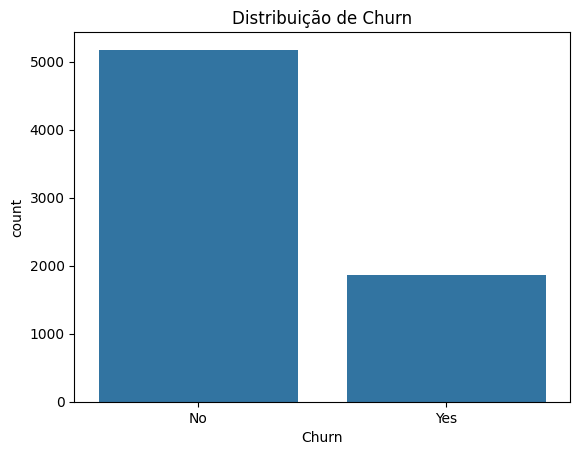

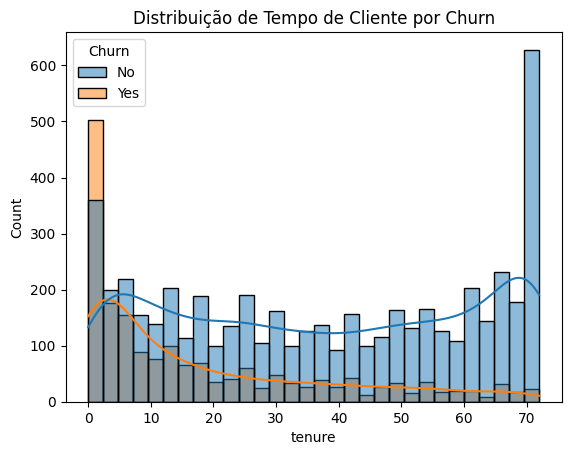

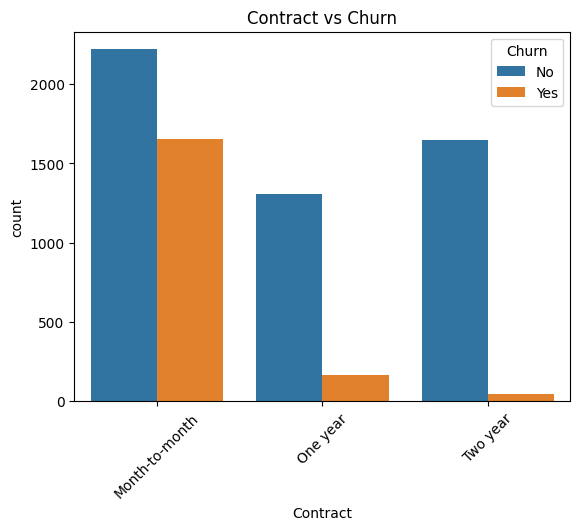

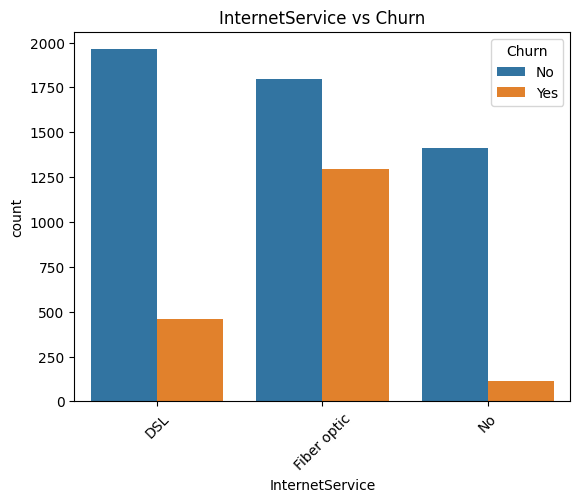

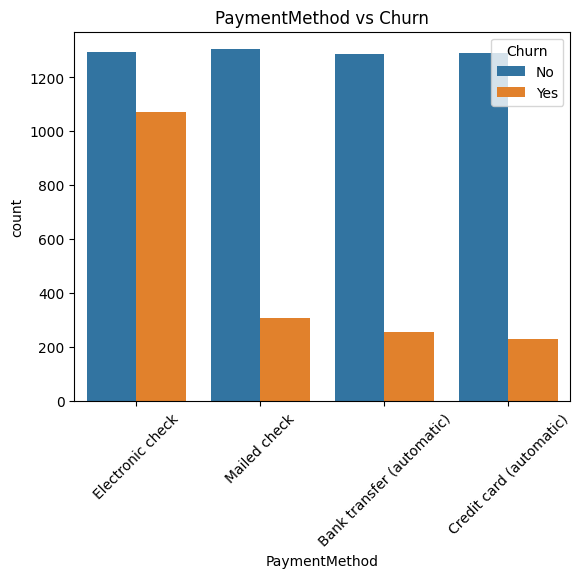

In [7]:


# Distribuição da variável target
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Churn')
plt.show()

# Distribuição de tenure vs Churn
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title('Distribuição de Tempo de Cliente por Churn')
plt.show()

# Relação de algumas variáveis categóricas vs Churn
for col in ['Contract', 'InternetService', 'PaymentMethod']:
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()


## 3. Pré-processamento dos dados

- Conversão de variáveis binárias (Yes/No → 1/0)  
- Padronização de variáveis numéricas  
- Codificação *One Hot Encoding* para variáveis categóricas  
- Preparação do dataframe final para o modelo

In [8]:
# Map para variaveis binarias
bin_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in bin_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [9]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)

In [10]:
one_hot_cols = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod', 'gender', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingMovies', 'StreamingTV']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
drop_cols = ['customerID'] + one_hot_cols + num_cols

# Pipeline de transformação
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('onehot', OneHotEncoder(drop='first'), one_hot_cols)
    ],
    remainder='drop'  # descarta as outras colunas
)

pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# Aplicar transformação
transformed_array = pipe.fit_transform(df)

# Nome das colunas
num_scaled_cols = num_cols
one_hot_encoded_cols = pipe.named_steps['preprocessor'] \
                           .named_transformers_['onehot'] \
                           .get_feature_names_out(one_hot_cols)
all_cols = list(num_scaled_cols) + list(one_hot_encoded_cols)

# Transformar em DataFrame
transformed_df = pd.DataFrame(transformed_array, columns=all_cols, index=df.index)

# Concatenar com as colunas que não queremos transformar
df_final = pd.concat([df.drop(columns=drop_cols), transformed_df], axis=1)

df_final.head()


,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,tenure,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes
0,0,1,0,0,1,0,-1.277445,-1.160323,-0.992611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0.066327,-0.259629,-0.172165,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,1,1,-1.236724,-0.362660,-0.958066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0.514251,-0.746535,-0.193672,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0,0,1,1,1,-1.236724,0.197365,-0.938874,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_final.shape

(7043, 31)

In [12]:
# Verificar valores nulos
df_final.isna().any()

SeniorCitizen                            False
Partner                                  False
Dependents                               False
PhoneService                             False
PaperlessBilling                         False
Churn                                    False
tenure                                   False
MonthlyCharges                           False
TotalCharges                             False
MultipleLines_No phone service           False
MultipleLines_Yes                        False
InternetService_Fiber optic              False
InternetService_No                       False
Contract_One year                        False
Contract_Two year                        False
PaymentMethod_Credit card (automatic)    False
PaymentMethod_Electronic check           False
PaymentMethod_Mailed check               False
gender_Male                              False
OnlineSecurity_No internet service       False
OnlineSecurity_Yes                       False
OnlineBackup_

## 4. Divisão dos dados e balanceamento da variável target

O dataset original é desbalanceado (muito mais clientes que ficam do que os que saem).
Para corrigir, aplicamos **SMOTE**, que gera exemplos sintéticos da classe minoritária.


In [13]:
X = df_final.drop(columns='Churn')
y = df_final['Churn']

print("Distribuição original:")
print(y.value_counts(normalize=True) * 100)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nDistribuição após SMOTE:")
print(y_resampled.value_counts(normalize=True) * 100)

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Distribuição original:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64

Distribuição após SMOTE:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64


## 5. Criação do modelo Random Forest a partir do GridSearch

In [14]:

# Definindo o modelo base
modelo_RFC = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Definindo a grade de hiperparâmetros para testar
param_grid = {
    'n_estimators': [200, 400, 500],
    'max_depth': [None, 8, 10, 12, 15],
    'min_samples_split': [5, 10], 
    'min_samples_leaf': [3, 5],  
    'max_features': ['sqrt', 'log2', None]
}

# Criando o GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo_RFC,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,             # paraleliza usando todos os núcleos
    verbose=2              # mostra o progresso
)

# Rodando o GridSearch
grid_search.fit(x_train, y_train)
modelo_RFC_cv = grid_search.best_estimator_

# Resultados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia:", grid_search.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Melhores parâmetros: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 500}
Melhor acurácia: 0.8363139804719996


## 6. Avaliação do modelo no conjunto de teste

In [15]:
modelo_RFC_cv.fit(x_train, y_train)

y_pred = modelo_RFC_cv.predict(x_test)
y_proba = modelo_RFC_cv.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusão:\n", cm)

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))


Acurácia: 0.85

Matriz de confusão:
 [[845 176]
 [136 913]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1021
           1       0.84      0.87      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



## Matriz de Confusão
Visualização da matriz de confusão para avaliar o desempenho do modelo em classificar corretamente clientes que saem e permanecem.

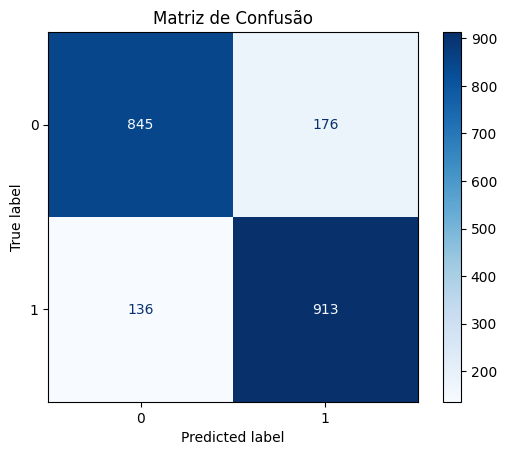

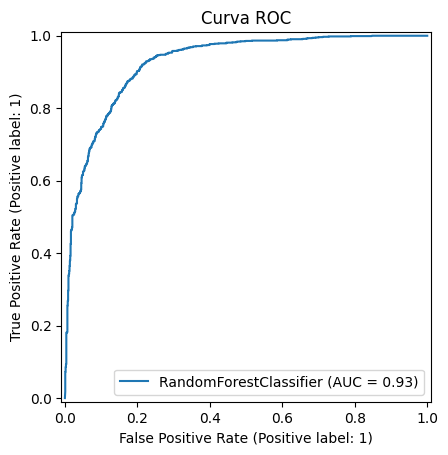

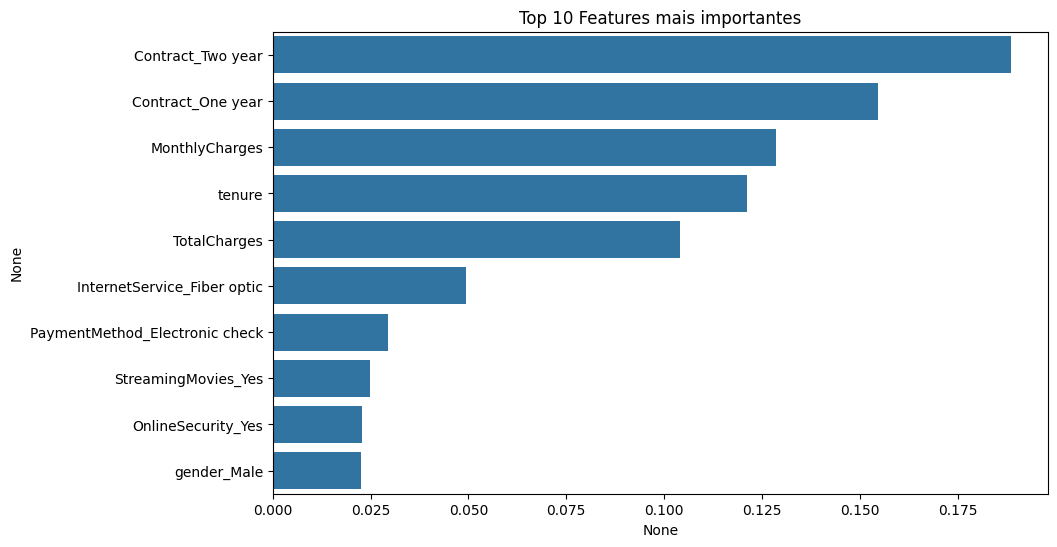

In [16]:
# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(modelo_RFC_cv, x_test, y_test, display_labels=[0,1], cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(modelo_RFC_cv, x_test, y_test)
plt.title("Curva ROC")
plt.show()

# Importância das features
importances = modelo_RFC_cv.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title('Top 10 Features mais importantes')
plt.show()

## 7. Criar pipeline final e salvar Modelo

In [17]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('onehot', OneHotEncoder(drop='first'), one_hot_cols)
])

pipeline_final = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        class_weight='balanced',
        random_state=42
    ))
])

X = df.drop(columns='Churn')
y = df['Churn']

pipeline_final.fit(X, y)

# Salvar o modelo
joblib.dump(pipeline_final, "pipeline_churn.pkl")


['pipeline_churn.pkl']